<a href="https://colab.research.google.com/github/random-words/colab-notebooks/blob/main/06__transfer_learning_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In [ ]:
!nvidia-smi

Tue Feb  4 23:16:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-05 00:33:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-05 00:33:33 (24.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# 101 Food Classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-02-04 23:16:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   141MB/s    in 16s     

2025-02-04 23:16:56 (94.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 image

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode="categorical")
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               image_size=IMG_SIZE,
                                                                               label_mode="categorical",
                                                                               shuffle=False) # don't shuffle test data for pred analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training model

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
    # layers.Rescaling(1/255.) # don't needed with our model
], name="data_augmentation")

In [ ]:
# Build model

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False) # backbone model
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,), name="input_layer")
x = data_augmentation(inputs) # augment images (only on training phase)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # compress data tensors into feature vector
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax",
                       name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
initial_epochs = 5

In [ ]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=initial_epochs,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data_all_10_percent,
                                           validation_steps=int(0.15 * len(test_data_all_10_percent)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 97s 343ms/step - accuracy: 0.1345 - loss: 4.0931 - val_accuracy: 0.3729 - val_loss: 2.8491
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 336ms/step - accuracy: 0.4138 - loss: 2.6134 - val_accuracy: 0.4783 - val_loss: 2.2425
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 353ms/step - accuracy: 0.4916 - loss: 2.1936 - val_accuracy: 0.5077 - val_loss: 2.0148
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - accuracy: 0.5270 - loss: 1.9625 - val_accuracy: 0.5241 - val_loss: 1.9031
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 352ms/step - accuracy: 0.5542 - loss: 1.8274 - val_accuracy: 0.5299 - val_loss: 1.8402


In [ ]:
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.5508 - loss: 1.7326


[1.649283766746521, 0.5666138529777527]

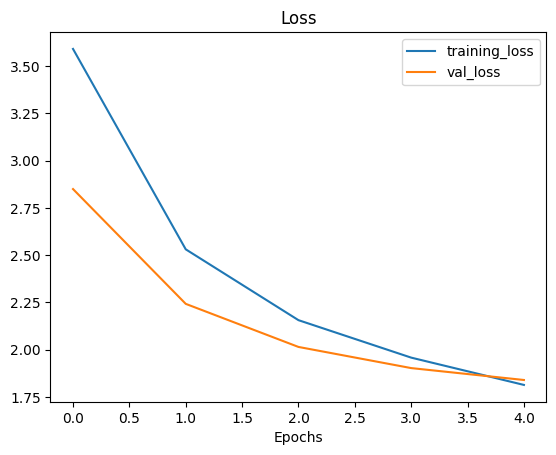

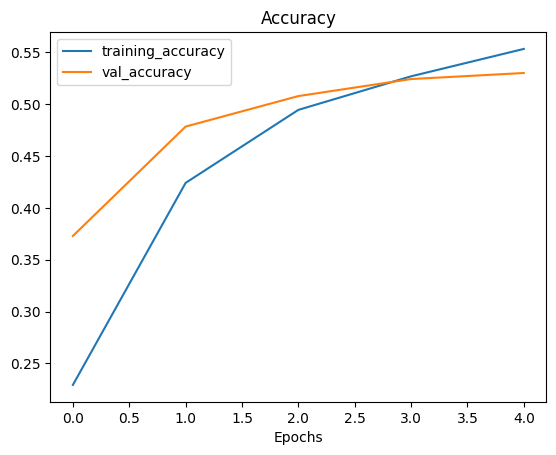

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze some layers
base_model.trainable = True

# Freeze all except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile the model (with lower learning rate)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling2d True
output_layer True


In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
fine_tune_epochs = initial_epochs + 5

In [ ]:
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data_all_10_percent,
                                                     validation_steps=int(0.15 * len(test_data_all_10_percent)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 65s 219ms/step - accuracy: 0.5462 - loss: 1.9514 - val_accuracy: 0.5019 - val_loss: 1.9994
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.5799 - loss: 1.7955 - val_accuracy: 0.5156 - val_loss: 1.8983
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 353ms/step - accuracy: 0.6132 - loss: 1.6753 - val_accuracy: 0.5347 - val_loss: 1.8210
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 140s 346ms/step - accuracy: 0.6231 - loss: 1.6174 - val_accuracy: 0.5487 - val_loss: 1.7616
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.6270 - loss: 1.5323 - val_accuracy: 0.5487 - val_loss: 1.7402
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.6374 - loss: 1.5243 - val_accuracy: 0.5522 - val_loss: 1.7240


In [ ]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data_all_10_percent)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.5758 - loss: 1.6062


[1.4821211099624634, 0.6027326583862305]

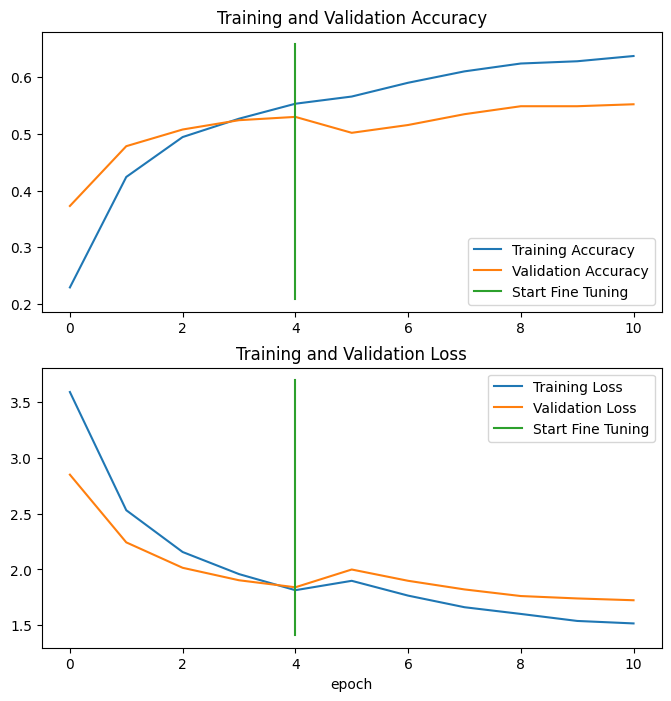

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=initial_epochs)

## Model Deployment

In [ ]:
# Save model
model.save("saved_models/model_1.keras")

In [ ]:
# Load model
loaded_model = tf.keras.models.load_model("saved_models/model_1.keras")

In [ ]:
# Evaluate model and compare it to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.5758 - loss: 1.6062


[1.4821211099624634, 0.6027326583862305]

In [ ]:
# results should be very similar
all_classes_10_percent_fine_tune_results

[1.4821211099624634, 0.6027326583862305]

## Model Evaluation

In [ ]:
import tensorflow as tf

# download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2025-02-04 23:36:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  81.8MB/s    in 0.5s    

2025-02-04 23:36:15 (81.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

ValueError: File format not supported: filepath=06_101_food_class_10_percent_saved_big_dog_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(06_101_food_class_10_percent_saved_big_dog_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
import tensorflow as tf
from tensorflow import keras

# 1. Create TFSMLayer
saved_model_layer = keras.layers.TFSMLayer(
    "06_101_food_class_10_percent_saved_big_dog_model",
    call_endpoint="serving_default"  # Make sure this matches your model's serving signature
)

# 2. Wrap this layer into a Keras Model
#    (Assuming your model expects input shape [None, 224, 224, 3]; adjust as necessary.)
inputs = keras.Input(shape=(224, 224, 3))
outputs = saved_model_layer(inputs)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [ ]:
# Example (in TF 2.x or older Keras)
model.save("saved_models/my_model.h5")

AttributeError: 'UninitializedVariable' object has no attribute 'path'

In [ ]:
# evaluate downloaded model
downloaded_model_results = model.evaluate(test_data_all_10_percent)
downloaded_model_results

AttributeError: 'UninitializedVariable' object has no attribute 'regularizer'

## Making predictions with trained model

In [ ]:
preds_probs = model.predict(test_data_all_10_percent, verbose=1)

In [ ]:
len(test_data_all_10_percent)

In [ ]:
len(preds_probs)

In [ ]:
preds_probs.shape

In [ ]:
preds_probs[:10]

In [ ]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

In [ ]:
preds_probs[0].argmax()

In [ ]:
test_data_all_10_percent.class_names

In [ ]:
test_data_all_10_percent.class_names[preds_probs[0].argmax()]

In [ ]:
# Get pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

In [ ]:
len(pred_classes)

In [ ]:
test_data_all_10_percent

In [ ]:
# To get test labels we need to unravel our test_data Batch
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

In [ ]:
len(y_labels)

## Evaluating predictions

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

NameError: name 'y_labels' is not defined

In [ ]:
import numpy as np
np.isclose(results_loaded_model[1], sklearn_accuracy)

NameError: name 'results_loaded_model' is not defined

## Visualize Performance

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = test_data_all_10_percent.class_names
class_names

NameError: name 'test_data_all_10_percent' is not defined

In [ ]:
import matplotlib.pyplot as plt

NameError: name 'y_labels' is not defined

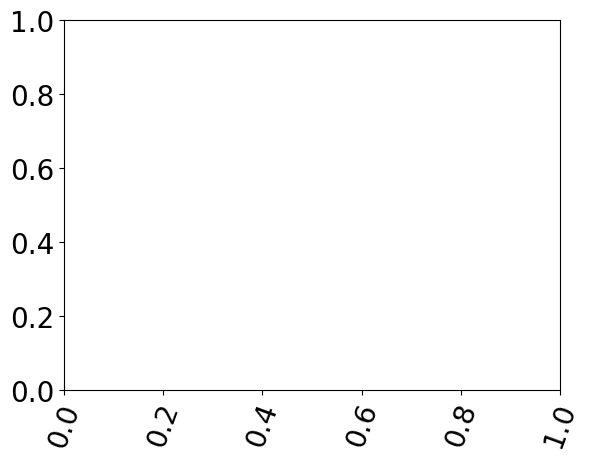

In [ ]:
plt.xticks(rotation=70, fontsize=20)
plt.yticks(fontsize=20)
make_confusion_matrix(y_labels,
                      pred_classes,
                      class_names,
                      figsize=(100, 100),
                      text_size=20)

In [ ]:
from sklearn.metrics import classification_report

* metrics evaluation class-by-class

In [ ]:
print(classification_report(y_labels, pred_classes))

NameError: name 'y_labels' is not defined

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

NameError: name 'y_labels' is not defined

In [ ]:
# create empty dictionary for key-value pair of index-f1-score
class_f1_scores = {}

# loop through classification report dictionary items
for key, values_dict in classification_report_dict.items():
  if key == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(key)]] = values_dict["f1-score"]

class_f1_scores

NameError: name 'classification_report_dict' is not defined

In [ ]:
# Turn dictionary into dataframe
import pandas as pd

f1_scores = pd.DataFrame(class_f1_scores).sort_values("f1-score", ascending=False)

KeyError: 'f1-score'

In [ ]:
f1_scores.head()

NameError: name 'f1_scores' is not defined

In [ ]:
f1_scores.tail()

NameError: name 'f1_scores' is not defined

In [ ]:
import seaborn as sns

In [ ]:
sns.barplot(f1_scores)

NameError: name 'f1_scores' is not defined

## Visualization with our own food images

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [ ]:
# Create a function to load and prepare images
def load_and_pred_image(filename, img_shape=224, scale=True):
  # read in image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # resize image
  img = tf.image.resize(img, (img_shape, img_shape))

  if scale:
    # rescale image
    return img/255.
  else:
    return img

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(3):
  # choose random image from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_pred_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot images
  plt.subplot(1, 3, i+1)
  # if not properly working, delete division
  plt.imshow(img/255)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}",
            c=title_color)
  plt.axis(False);

NameError: name 'class_names' is not defined

<Figure size 1700x1000 with 0 Axes>

### Finding most wrong predictions

In [ ]:
# Get all the image filepaths in the test dataset
filepaths = []
for filepath in test_data_all_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                                    shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

NameError: name 'test_data_all_10_percent' is not defined

In [ ]:
# Create a DataFrame
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_prob": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})

pred_df

NameError: name 'y_labels' is not defined

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

NameError: name 'pred_df' is not defined

In [ ]:
# sort dataframe
# pred_df.groupby("pred_correct").iloc["False"].sort_values("pred_conf")

In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

NameError: name 'pred_df' is not defined

In [ ]:
# visualize false high predictions
images_to_view = 9
start_index = 0

plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_pred_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only few parameters from row
  plt.imshow(img/255.)
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}")

NameError: name 'top_100_wrong' is not defined

<Figure size 1500x1000 with 0 Axes>

## Test on our images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2025-02-05 02:28:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  35.4MB/s    in 0.4s    

2025-02-05 02:28:17 (35.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



NameError: name 'unzip_data' is not defined

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

FileNotFoundError: [Errno 2] No such file or directory: 'custom_food_images'

In [ ]:
# Make preds and plot custom images
for img in custom_food_images:
  img = load_and_pred_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # shape=(1, 224, 224, 3)
  pred_class = class_names[pred_prob.argmax()] # get index with the highest value

  # plot
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

NameError: name 'custom_food_images' is not defined

# Exercises Section

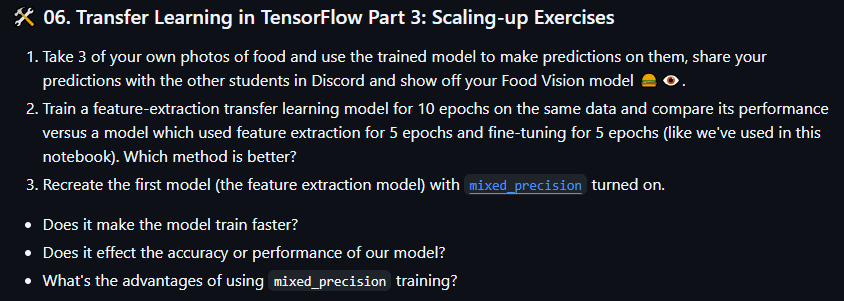

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2025-02-05 13:55:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-05 13:55:33 (68.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-steak.jpeg

--2025-02-05 13:56:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  --.-KB/s    in 0.08s   

2025-02-05 13:56:16 (35.6 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]

--2025-02-05 13:56:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
H

In [12]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2025-02-05 14:05:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 173.194.217.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  93.1MB/s    in 22s     

2025-02-05 14:06:06 (70.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [13]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [18]:
tf.random.set_seed(42)

train_data = image_dataset_from_directory(train_dir,
                                          label_mode="categorical",
                                          image_size=(224, 224))
test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=(224, 224))

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
os.mkdir("checkpoints")

In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoints/model_checkpoint.weights.h5",
                                                         save_weights_only=True)

In [9]:
tf.random.set_seed(42)

augmentation_layer = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2)
])

In [19]:
# 1. Create model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = augmentation_layer(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation="softmax",
                       name="output_layer")(x)

feature_extraction_model = tf.keras.models.Model(inputs, outputs)

feature_extraction_model.compile(loss="categorical_crossentropy",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=["accuracy"])

In [20]:
feature_extractor_epochs = 10

In [25]:
tf.random.set_seed(42)

model.fit(train_data,
          epochs=feature_extractor_epochs,
          steps_per_epoch=len(train_data),
          callbacks=[create_tensorboard_callback("tensorboard", "feature_extraction_model"),
                     checkpoint_callback])

Saving TensorBoard log files to: tensorboard/feature_extraction_model/20250205-141758
Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 644s 3s/step - accuracy: 0.1514 - loss: 4.0042
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.4450 - loss: 2.4577
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.5223 - loss: 2.0283
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.5589 - loss: 1.8191
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.5851 - loss: 1.6619
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.6104 - loss: 1.5473
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.6380 - loss: 1.4505
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.6573 - loss: 1.3744
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.6713 - loss: 1.3180
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.6785 - loss: 1.2484


In [26]:
base_model.trainable = True

for layer in base_model.layers[:5]:
  layer.trainable = False

In [27]:
feature_extraction_model.compile(loss="categorical_crossentropy",
                                 optimizer=tf.keras.optimisers.Adam(0.0001),
                                 metrics=["accuracy"])

AttributeError: module 'tensorflow.keras' has no attribute 'optimisers'

In [ ]:
tf.random.set_seed(42)

feature_extraction_model.fit(train_data,
                             epochs=feature_extractor_epochs,
                             steps_per_epoch=len(train_data),
                             initial_epochs=history.epochs[-5],
                             callbacks=[create_tensorboard_callback("tensorboard", "fine_tuned_model"),
                                       checkpoint_callback])